In [83]:
import numpy as np
import pandas as pd
import math
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from pylab import *
%matplotlib inline

In [4]:
colnames = pd.read_csv('spam_colnames.csv', header=None, squeeze=1).tolist() 
df = pd.read_csv('spambase.data', header=None, names=colnames)

In [5]:
df.describe()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,target
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,...,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,...,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285,0.394045
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,...,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851,0.488698
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.065000,0.000000,0.000000,0.000000,0.000000,2.276000,15.000000,95.000000,0.000000
75%,0.000000,0.000000,0.420000,0.000000,0.380000,0.000000,0.000000,0.000000,0.000000,0.160000,...,0.000000,0.188000,0.000000,0.315000,0.052000,0.000000,3.706000,43.000000,266.000000,1.000000
max,4.540000,14.280000,5.100000,42.810000,10.000000,5.880000,7.270000,11.110000,5.260000,18.180000,...,4.385000,9.752000,4.081000,32.478000,6.003000,19.829000,1102.500000,9989.000000,15841.000000,1.000000


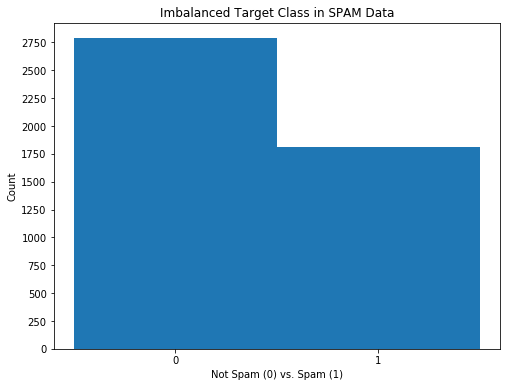

In [253]:
# checking balance of target class

figure(figsize=(8,6))
plt.hist(df.target, bins=np.arange(3)-0.5)
plt.title("Imbalanced Target Class in SPAM Data")
plt.xlabel('Not Spam (0) vs. Spam (1)')
plt.ylabel('Count')
plt.xticks([0,1])
plt.yticks(np.arange(0,3000, 250))
plt.show()

The target class is imbalanced, but not severely so. The minimum class size in the target class is still around 1750 compared to the 2750 of majority class. This is reasonable enough that synthetic data most likely will not need to be produced, and stratified sampling methods will be employed first

Creating a copy of the dataset which removes outliers using an isolation forest to determine where in high-dimensional data we have cases that fall outside the majority

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X = df.iloc[:, 0:len(df.columns)-1]
y = df.target  

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33)

In [10]:
from sklearn.ensemble import IsolationForest

In [11]:
iso_clf = IsolationForest(behaviour="new", max_samples=100, random_state=0, contamination="auto")

In [12]:
iso_clf.fit(X_train)
iso_y_pred_train = iso_clf.predict(X_train)

In [13]:
print "Detected outliers in the trianing data:"
pd.Series(iso_y_pred_train).value_counts()

Detected outliers in the trianing data:


 1    3061
-1      21
dtype: int64

In [14]:
# setting up copies of the training data sets which will be compared to the raw data 
X_train2 = X_train[iso_y_pred_train==1]
y_train2 = y_train[iso_y_pred_train==1]

### SVM Classification

In [15]:
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import pickle

#### Linear kernel:

In [20]:
# version two of these arrays is testing the models based on the training set with outliers removed
svm_linear_resub = []
svm_linear_gen = []
svm_linear_resub_norm = []
svm_linear_gen_norm = []

svm_linear_resub2 = []
svm_linear_gen2 = []
svm_linear_resub2_norm = []
svm_linear_gen2_norm =[]

for i in range(-10, 2):
    clf = SVC(kernel='linear', C=10**i)
    
    # fitting and predicting for the original data set
    clf.fit(X_train, y_train)
    svm_linear_resub.append([10**i, 1-accuracy_score(y_train, clf.predict(X_train))])
    svm_linear_gen.append([10**i, 1-accuracy_score(y_test, clf.predict(X_test))])
    
    #fitting and predicting for the original dataset that is normalized
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    tmp_train = scaler.transform(X_train)
    tmp_test = scaler.transform(X_test)
    clf.fit(tmp_train, y_train)
    svm_linear_resub_norm.append([10**i, 1-accuracy_score(y_train, clf.predict(tmp_train))])
    svm_linear_gen_norm.append([10**i, 1-accuracy_score(y_test, clf.predict(tmp_test))])
    
    #fitting and predicting for the dataset which has outliers removed from training
    clf.fit(X_train2, y_train2)
    svm_linear_resub2.append([10**i, 1-accuracy_score(y_train2, clf.predict(X_train2))])
    svm_linear_gen2.append([10**i, 1-accuracy_score(y_test, clf.predict(X_test))])
    
    #fitting and predicting for the dataset which has outliers removed from training and is normalized
    scaler.fit(X_train2)
    tmp_train2 = scaler.transform(X_train2)
    tmp_test2 = scaler.transform(X_test)
    clf.fit(X_train2, y_train2)
    svm_linear_resub2_norm.append([10**i, 1-accuracy_score(y_train2, clf.predict(X_train2))])
    svm_linear_gen2_norm.append([10**i, 1-accuracy_score(y_test, clf.predict(X_test))])
    

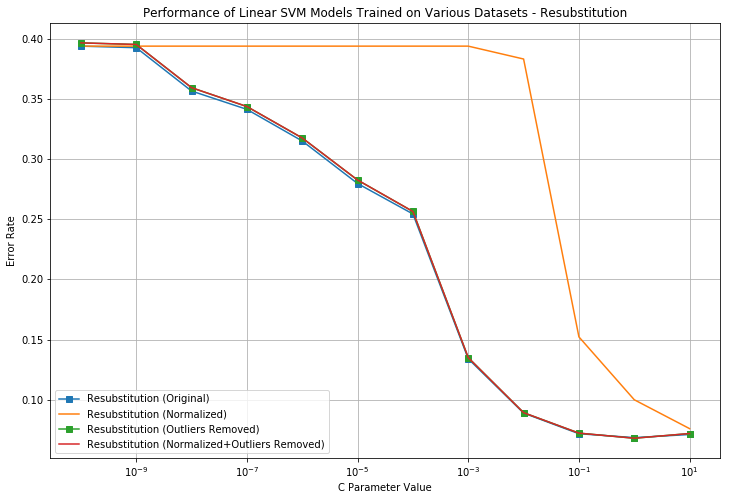

In [21]:
figure(figsize=(12,8))
plt.semilogx(*zip(*svm_linear_resub), marker='s')
plt.semilogx(*zip(*svm_linear_resub_norm))
plt.semilogx(*zip(*svm_linear_resub2), marker='s')
plt.semilogx(*zip(*svm_linear_resub2_norm))
plt.grid()
plt.xlabel("C Parameter Value")
plt.ylabel("Error Rate")
plt.legend(["Resubstitution (Original)", "Resubstitution (Normalized)",  
            "Resubstitution (Outliers Removed)", "Resubstitution (Normalized+Outliers Removed)"])
plt.title("Performance of Linear SVM Models Trained on Various Datasets - Resubstitution")
plt.show()

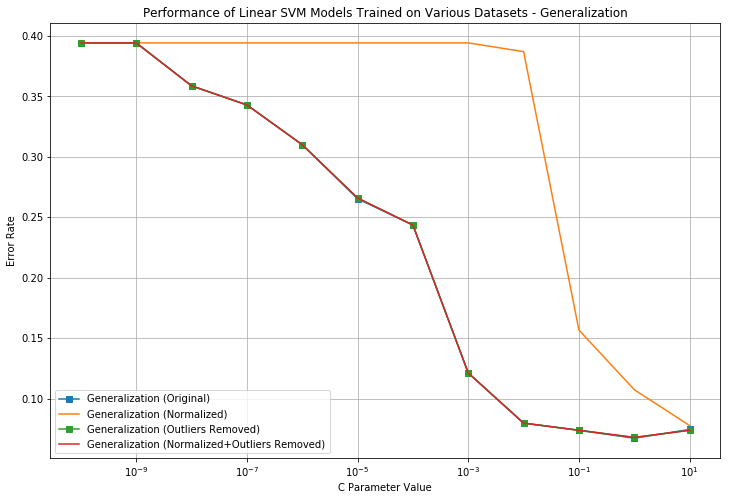

In [22]:
figure(figsize=(12,8))
plt.semilogx(*zip(*svm_linear_gen), marker='s')
plt.semilogx(*zip(*svm_linear_gen_norm))
plt.semilogx(*zip(*svm_linear_gen2), marker='s')
plt.semilogx(*zip(*svm_linear_gen2_norm))
plt.grid()
plt.xlabel("C Parameter Value")
plt.ylabel("Error Rate")
plt.legend(["Generalization (Original)", "Generalization (Normalized)",
            "Generalization (Outliers Removed)", "Generalization (Normalized+Outliers Removed)"])
plt.title("Performance of Linear SVM Models Trained on Various Datasets - Generalization")
plt.show()

#### RBF Kernel SVM

In [23]:
def frange(start, stop, by):
    while start < stop:
        yield start
        start += by

In [24]:
def gridSVMrbfResub(C_range, sig_range, xtrain, xtest, ytrain, ytest):
    z = []
    for i in range(0, len(sig_range)):
        partial = []
        for j in range(0, len(C_range)):
            clf = SVC(kernel='rbf', C=10**C_range[j], gamma=1./(2*sig_range[i]))
            clf.fit(xtrain, ytrain)
            y_pred = clf.predict(xtrain)
            partial.append(1-accuracy_score(ytrain, y_pred))
            
        z.append(partial)
    return z

In [25]:
def gridSVMrbfGen(C_range, sig_range, xtrain, xtest, ytrain, ytest):
    z = []
    for i in range(0, len(sig_range)):
        partial = []
        for j in range(0, len(C_range)):
            clf = SVC(kernel='rbf', C=10**C_range[j], gamma=1./(2*sig_range[i]))
            clf.fit(xtrain, ytrain)
            y_pred = clf.predict(xtest)
            partial.append(1-accuracy_score(ytest, y_pred))
            
        z.append(partial)
    return z

In [40]:
x_resub = np.arange(-3., 6., 1)
y_resub = np.array([10**x for x in frange(0. ,10. , 1)])
xi, yi = np.meshgrid(x_resub, y_resub)

#the original dataset
z_resub = gridSVMrbfResub(x_resub, y_resub, X_train, X_test, y_train, y_test)
z_gen = gridSVMrbfGen(x_resub, y_resub, X_train, X_test, y_train, y_test)

# using the normalized dataset
scaler=MinMaxScaler()
scaler.fit(X_train)
tmp_xtrain = scaler.transform(X_train)
tmp_xtest = scaler.transform(X_test)
z_resub_norm = gridSVMrbfResub(x_resub, y_resub, tmp_xtrain, tmp_xtest, y_train, y_test)
z_gen_norm = gridSVMrbfGen(x_resub, y_resub, tmp_xtrain, tmp_xtest, y_train, y_test)

# using the original dataset with training outliers removed
z_resub2 = gridSVMrbfResub(x_resub, y_resub, X_train2, X_test, y_train2, y_test)
z_gen2 = gridSVMrbfGen(x_resub, y_resub, X_train2, X_test, y_train2, y_test)

# using the dataset with training outliers removed and normalized
scaler=MinMaxScaler()
scaler.fit(X_train2)
tmp_xtrain2 = scaler.transform(X_train2)
tmp_xtest2 = scaler.transform(X_test)
z_resub2_norm = gridSVMrbfResub(x_resub, y_resub, tmp_xtrain2, tmp_xtest2, y_train2, y_test)
z_gen2_norm = gridSVMrbfGen(x_resub, y_resub, tmp_xtrain2, tmp_xtest2, y_train2, y_test)

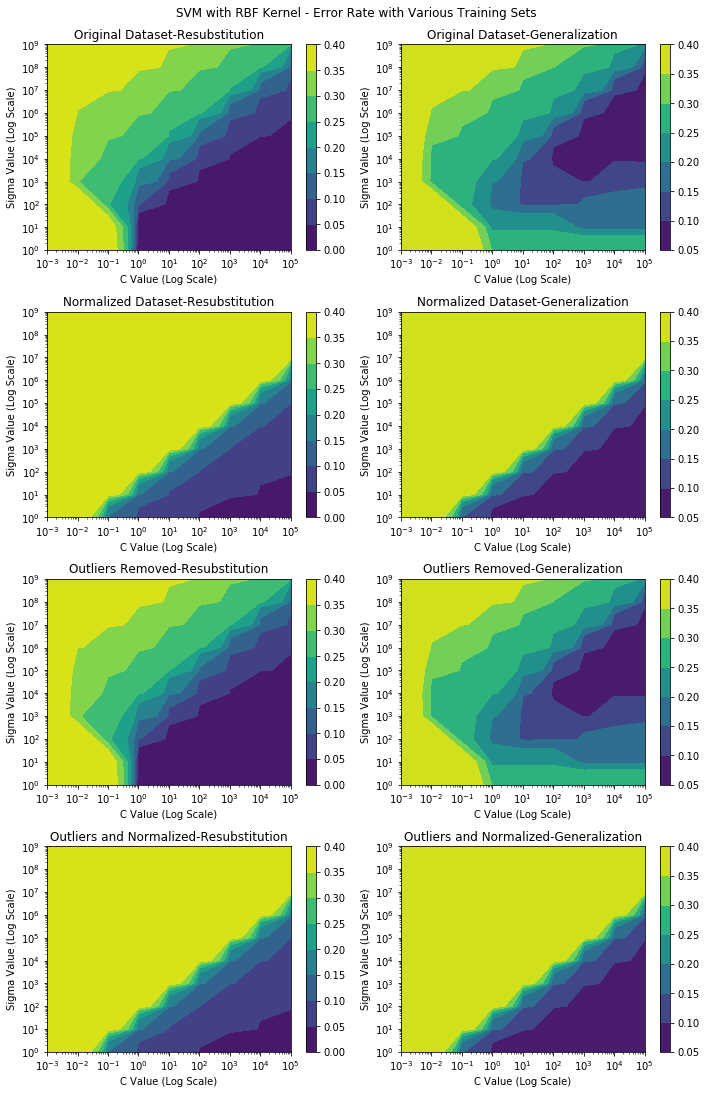

In [119]:
fig = plt.figure(figsize=(10,15))
st = fig.suptitle('SVM with RBF Kernel - Error Rate with Various Training Sets')

ax1=fig.add_subplot(421)
plt.contourf(10**xi, yi, z_resub)
plt.semilogx()
plt.semilogy()
plt.xlabel('C Value (Log Scale)')
plt.ylabel('Sigma Value (Log Scale)')
plt.colorbar()
plt.title("Original Dataset-Resubstitution")

ax1=fig.add_subplot(422)
plt.contourf(10**xi, yi, z_gen)
plt.semilogx()
plt.semilogy()
plt.xlabel('C Value (Log Scale)')
plt.ylabel('Sigma Value (Log Scale)')
plt.colorbar()
plt.title("Original Dataset-Generalization")

ax1=fig.add_subplot(423)
plt.contourf(10**xi, yi, z_resub_norm)
plt.semilogx()
plt.semilogy()
plt.xlabel('C Value (Log Scale)')
plt.ylabel('Sigma Value (Log Scale)')
plt.colorbar()
plt.title("Normalized Dataset-Resubstitution")

ax1=fig.add_subplot(424)
plt.contourf(10**xi, yi, z_gen_norm)
plt.semilogx()
plt.semilogy()
plt.xlabel('C Value (Log Scale)')
plt.ylabel('Sigma Value (Log Scale)')
plt.colorbar()
plt.title("Normalized Dataset-Generalization")

ax1=fig.add_subplot(425)
plt.contourf(10**xi, yi, z_resub2)
plt.semilogx()
plt.semilogy()
plt.xlabel('C Value (Log Scale)')
plt.ylabel('Sigma Value (Log Scale)')
plt.colorbar()
plt.title("Outliers Removed-Resubstitution")

ax1=fig.add_subplot(426)
plt.contourf(10**xi, yi, z_gen2)
plt.semilogx()
plt.semilogy()
plt.xlabel('C Value (Log Scale)')
plt.ylabel('Sigma Value (Log Scale)')
plt.colorbar()
plt.title("Outliers Removed-Generalization")

ax1=fig.add_subplot(427)
plt.contourf(10**xi, yi, z_resub2_norm)
plt.semilogx()
plt.semilogy()
plt.xlabel('C Value (Log Scale)')
plt.ylabel('Sigma Value (Log Scale)')
plt.colorbar()
plt.title("Outliers and Normalized-Resubstitution")

ax1=fig.add_subplot(428)
plt.contourf(10**xi, yi, z_gen2_norm)
plt.semilogx()
plt.semilogy()
plt.xlabel('C Value (Log Scale)')
plt.ylabel('Sigma Value (Log Scale)')
plt.colorbar()
plt.title("Outliers and Normalized-Generalization")

st.set_y(1.01)
fig.subplots_adjust(top=0.75)
plt.tight_layout()
plt.show()

Comparing the best models from Linear kernel and RBF kernel SVMs

In [194]:
l_clf = SVC(kernel="linear", C=10**-1)
l_clf.fit(X_train, y_train)
l_ypred_train = l_clf.predict(X_train)
l_ypred_test = l_clf.predict(X_test)

In [199]:
print "Training Error rate of best SVM with linear kernel: {0:.2f}%".format((1-accuracy_score(y_train, l_ypred_train))*100)
print "Confusion matrix for the best model on resubstitution: \n",confusion_matrix(y_train, l_ypred_train)
print '\n'
print "Testing Error rate of best SVM with linear kernel: {0:.2f}%".format((1-accuracy_score(y_test, l_ypred_test))*100)
print "Confusion matrix for the best model on generalization: \n",confusion_matrix(y_test, l_ypred_test)

Training Error rate of best SVM with linear kernel: 7.17%
Confusion matrix for the best model on resubstitution: 
[[1776   92]
 [ 129 1085]]


Testing Error rate of best SVM with linear kernel: 7.37%
Confusion matrix for the best model on generalization: 
[[868  52]
 [ 60 539]]


In [205]:
scaler.fit(X_train)
xtrain_n, xtest_n = scaler.transform(X_train), scaler.transform(X_test)
rbf_clf = SVC(kernel="rbf", C=5, gamma=1./2.)
rbf_clf.fit(xtrain_n, y_train)
rbf_ypred_train = rbf_clf.predict(xtrain_n)
rbf_ypred_test = rbf_clf.predict(xtest_n)

In [207]:
print "Training Error rate of best SVM with rbf kernel: {0:.2f}%".format((1-accuracy_score(y_train, rbf_ypred_train))*100)
print "Confusion matrix for the best model on resubstitution: \n",confusion_matrix(y_train, rbf_ypred_train)
print '\n'
print "Testing Error rate of best SVM with rbf kernel: {0:.2f}%".format((1-accuracy_score(y_test, rbf_ypred_test))*100)
print "Confusion matrix for the best model on generalization: \n",confusion_matrix(y_test, rbf_ypred_test)

Training Error rate of best SVM with rbf kernel: 6.88%
Confusion matrix for the best model on resubstitution: 
[[1803   65]
 [ 147 1067]]


Testing Error rate of best SVM with rbf kernel: 7.50%
Confusion matrix for the best model on generalization: 
[[873  47]
 [ 67 532]]


### AdaBoost Classifcation

In [16]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [231]:
# version two of these arrays is testing the models based on the training set with outliers removed
ada_resub = []
ada_gen = []
ada_resub_norm = []
ada_gen_norm = []

ada_resub2 = []
ada_gen2 = []
ada_resub2_norm = []
ada_gen2_norm =[]

for i in range(5, 250, 10): 
    clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                             n_estimators=i, learning_rate=1)
    
    # fitting and predicting for the original data set
    clf.fit(X_train, y_train)
    ada_resub.append([i, 1-accuracy_score(y_train, clf.predict(X_train))])
    ada_gen.append([i, 1-accuracy_score(y_test, clf.predict(X_test))])
    
    #fitting and predicting for the original dataset that is normalized
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    tmp_train = scaler.transform(X_train)
    tmp_test = scaler.transform(X_test)
    clf.fit(tmp_train, y_train)
    ada_resub_norm.append([i, 1-accuracy_score(y_train, clf.predict(tmp_train))])
    ada_gen_norm.append([i, 1-accuracy_score(y_test, clf.predict(tmp_test))])
    
    #fitting and predicting for the dataset which has outliers removed from training
    clf.fit(X_train2, y_train2)
    ada_resub2.append([i, 1-accuracy_score(y_train2, clf.predict(X_train2))])
    ada_gen2.append([i, 1-accuracy_score(y_test, clf.predict(X_test))])
    
    #fitting and predicting for the dataset which has outliers removed from training and is normalized
    scaler.fit(X_train2)
    tmp_train2 = scaler.transform(X_train2)
    tmp_test2 = scaler.transform(X_test)
    clf.fit(tmp_train2, y_train2)
    ada_resub2_norm.append([i, 1-accuracy_score(y_train2, clf.predict(tmp_train2))])
    ada_gen2_norm.append([i, 1-accuracy_score(y_test, clf.predict(tmp_test2))])

In [ ]:
# version two of these arrays is testing the models based on the training set with outliers removed
Gada_resub = []
Gada_gen = []
Gada_resub_norm = []
Gada_gen_norm = []

Gada_resub2 = []
Gada_gen2 = []
Gada_resub2_norm = []
Gada_gen2_norm =[]

for i in range(5, 250, 10): 
    Gclf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                             n_estimators=i, learning_rate=1)
    
    # fitting and predicting for the original data set
    Gclf.fit(X_train, y_train)
    Gada_resub.append([i, 1-accuracy_score(y_train, Gclf.predict(X_train))])
    Gada_gen.append([i, 1-accuracy_score(y_test, Gclf.predict(X_test))])
    
    #fitting and predicting for the original dataset that is normalized
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    Gtmp_train = scaler.transform(X_train)
    Gtmp_test = scaler.transform(X_test)
    Gclf.fit(tmp_train, y_train)
    Gada_resub_norm.append([i, 1-accuracy_score(y_train, Gclf.predict(Gtmp_train))])
    Gada_gen_norm.append([i, 1-accuracy_score(y_test, Gclf.predict(Gtmp_test))])
    
    #fitting and predicting for the dataset which has outliers removed from training
    Gclf.fit(X_train2, y_train2)
    Gada_resub2.append([i, 1-accuracy_score(y_train2, Gclf.predict(X_train2))])
    Gada_gen2.append([i, 1-accuracy_score(y_test, Gclf.predict(X_test))])
    
    #fitting and predicting for the dataset which has outliers removed from training and is normalized
    scaler.fit(X_train2)
    Gtmp_train2 = scaler.transform(X_train2)
    Gtmp_test2 = scaler.transform(X_test)
    Gclf.fit(Gtmp_train2, y_train2)
    Gada_resub2_norm.append([i, 1-accuracy_score(y_train2, Gclf.predict(Gtmp_train2))])
    Gada_gen2_norm.append([i, 1-accuracy_score(y_test, Gclf.predict(Gtmp_test2))])

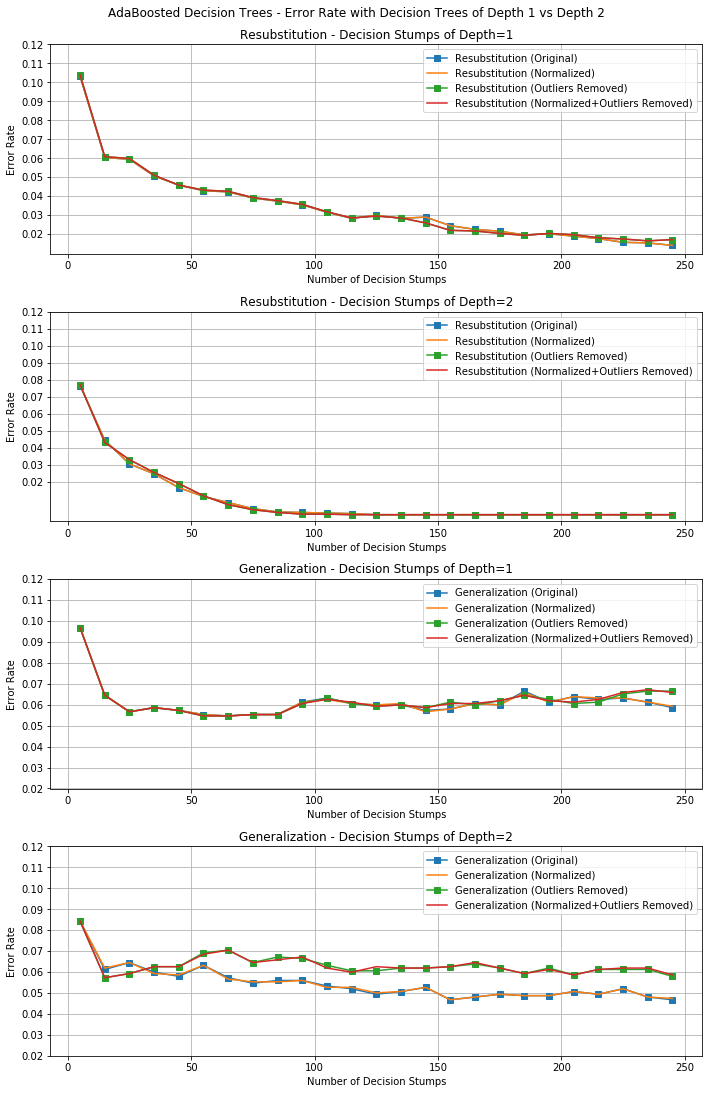

In [249]:
fig = plt.figure(figsize=(10,15))
st = fig.suptitle('AdaBoosted Decision Trees - Error Rate with Decision Trees of Depth 1 vs Depth 2')

ax1=fig.add_subplot(411)
plt.plot(*zip(*ada_resub), marker="s")
plt.plot(*zip(*ada_resub_norm))
plt.plot(*zip(*ada_resub2), marker="s")
plt.plot(*zip(*ada_resub2_norm))
plt.grid()
plt.xlabel("Number of Decision Stumps")
plt.ylabel("Error Rate")
plt.yticks(frange(0.02, 0.12, 0.01))
plt.legend(["Resubstitution (Original)", "Resubstitution (Normalized)",  
            "Resubstitution (Outliers Removed)", "Resubstitution (Normalized+Outliers Removed)"])
plt.title("Resubstitution - Decision Stumps of Depth=1")

ax1=fig.add_subplot(412)
plt.plot(*zip(*Gada_resub), marker="s")
plt.plot(*zip(*Gada_resub_norm))
plt.plot(*zip(*Gada_resub2), marker="s")
plt.plot(*zip(*Gada_resub2_norm))
plt.grid()
plt.xlabel("Number of Decision Stumps")
plt.ylabel("Error Rate")
plt.yticks(frange(0.02, 0.12, 0.01))
plt.legend(["Resubstitution (Original)", "Resubstitution (Normalized)",  
            "Resubstitution (Outliers Removed)", "Resubstitution (Normalized+Outliers Removed)"])
plt.title("Resubstitution - Decision Stumps of Depth=2")


ax1=fig.add_subplot(413)
plt.plot(*zip(*ada_gen), marker="s")
plt.plot(*zip(*ada_gen_norm))
plt.plot(*zip(*ada_gen2), marker="s")
plt.plot(*zip(*ada_gen2_norm))
plt.grid()
plt.xlabel("Number of Decision Stumps")
plt.ylabel("Error Rate")
plt.yticks(frange(0.02, 0.12, 0.01))
plt.legend(["Generalization (Original)", "Generalization (Normalized)",
            "Generalization (Outliers Removed)", "Generalization (Normalized+Outliers Removed)"])
plt.title("Generalization - Decision Stumps of Depth=1")

ax1=fig.add_subplot(414)
plt.plot(*zip(*Gada_gen), marker="s")
plt.plot(*zip(*Gada_gen_norm))
plt.plot(*zip(*Gada_gen2), marker="s")
plt.plot(*zip(*Gada_gen2_norm))
plt.grid()
plt.xlabel("Number of Decision Stumps")
plt.ylabel("Error Rate")
plt.yticks(frange(0.02, 0.12, 0.01))
plt.legend(["Generalization (Original)", "Generalization (Normalized)",
            "Generalization (Outliers Removed)", "Generalization (Normalized+Outliers Removed)"])
plt.title("Generalization - Decision Stumps of Depth=2")

st.set_y(1.01)
fig.subplots_adjust(top=0.75)
plt.tight_layout()
plt.show()

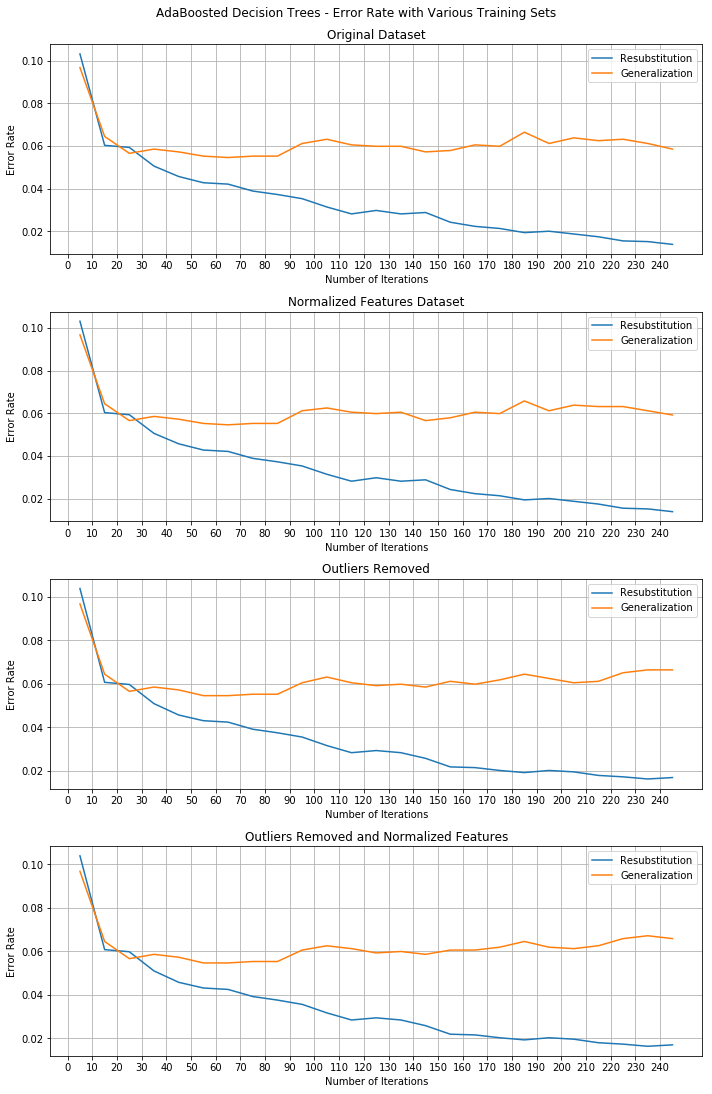

In [234]:
fig = plt.figure(figsize=(10,15))
st = fig.suptitle('AdaBoosted Decision Trees - Error Rate with Various Training Sets')

ax1=fig.add_subplot(411)
plt.plot(*zip(*ada_resub))
plt.plot(*zip(*ada_gen))
plt.xlabel('Number of Iterations')
plt.ylabel('Error Rate')
plt.xticks(range(0, 250, 10))
plt.grid()
plt.legend(['Resubstitution', 'Generalization'])
plt.title("Original Dataset")

ax1=fig.add_subplot(412)
plt.plot(*zip(*ada_resub_norm))
plt.plot(*zip(*ada_gen_norm))
plt.xlabel('Number of Iterations')
plt.ylabel('Error Rate')
plt.xticks(range(0, 250, 10))
plt.grid()
plt.legend(['Resubstitution', 'Generalization'])
plt.title("Normalized Features Dataset")

ax1=fig.add_subplot(413)
plt.plot(*zip(*ada_resub2))
plt.plot(*zip(*ada_gen2))
plt.xlabel('Number of Iterations')
plt.ylabel('Error Rate')
plt.xticks(range(0, 250, 10))
plt.grid()
plt.legend(['Resubstitution', 'Generalization'])
plt.title("Outliers Removed")

ax1=fig.add_subplot(414)
plt.plot(*zip(*ada_resub2_norm))
plt.plot(*zip(*ada_gen2_norm))
plt.xlabel('Number of Iterations')
plt.ylabel('Error Rate')
plt.xticks(range(0, 250, 10))
plt.grid()
plt.legend(['Resubstitution', 'Generalization'])
plt.title("Outliers Removed and Normalized Features")

st.set_y(1.01)
fig.subplots_adjust(top=0.75)
plt.tight_layout()
plt.show()

In [250]:
a_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                           n_estimators=60, learning_rate=1)
a_clf.fit(X_train, y_train)
ay_pred_train = a_clf.predict(X_train)
ay_pred_test = a_clf.predict(X_test)

In [252]:
print "Training Error rate of best AdaBoost model: {0:.2f}%".format((1-accuracy_score(y_train, ay_pred_train))*100)
print "Confusion matrix for the best model on resubstitution: \n",confusion_matrix(y_train, ay_pred_train)
print '\n'
print "Testing Error rate of best AdaBoost model: {0:.2f}%".format((1-accuracy_score(y_test, ay_pred_test))*100)
print "Confusion matrix for the best model on generalization: \n",confusion_matrix(y_test, ay_pred_test)

Training Error rate of best AdaBoost model: 4.06%
Confusion matrix for the best model on resubstitution: 
[[1813   55]
 [  70 1144]]


Testing Error rate of best AdaBoost model: 5.27%
Confusion matrix for the best model on generalization: 
[[879  41]
 [ 39 560]]
